In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras import layers, models

# Ensure TensorFlow uses GPU if available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU is available and memory growth is set")
    except RuntimeError as e:
        print(e)


In [2]:
import os
os.environ["PATH"] += os.pathsep + r'C:\Graphviz\bin'


In [3]:
# Generator to load data in batches
def load_data_in_batches(patient_list, batch_size):
    while True:
        np.random.shuffle(patient_list)
        
        for i in range(0, len(patient_list), batch_size):
            batch_patients = patient_list[i:i+batch_size]
            images, masks = [], []
            
            for patient in batch_patients:
                patient_path = os.path.join('Data/BraTS2021', patient)
                
                flair_path = os.path.join(patient_path, f'{patient}_flair.nii')
                t1ce_path = os.path.join(patient_path, f'{patient}_t1ce.nii')
                t2_path = os.path.join(patient_path, f'{patient}_t2.nii')
                seg_path = os.path.join(patient_path, f'{patient}_seg.nii')
                
                # Load the images using nibabel
                flair = nib.load(flair_path).get_fdata()
                t1ce = nib.load(t1ce_path).get_fdata()
                t2 = nib.load(t2_path).get_fdata()
                seg = nib.load(seg_path).get_fdata()
                
                # Stack the modalities (flair, t1ce, t2) along the channel axis
                stacked_image = np.stack([flair, t1ce, t2], axis=-1)
                
                images.append(stacked_image)
                masks.append(seg)
            
            # Convert to numpy arrays and normalize
            images = np.array(images)
            masks = np.expand_dims(np.array(masks), axis=-1)

            # Normalize
            images = images / np.max(images)  # Normalize images
            masks = masks / np.max(masks)  # Normalize masks
            
            yield images, masks


In [4]:
# List of patients
patients = os.listdir('Data/BraTS2021')

# Split into training and validation sets
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Set batch size
batch_size = 1  # Adjust batch size depending on memory

# Set up training and validation generators
train_generator = load_data_in_batches(train_patients, batch_size)
val_generator = load_data_in_batches(val_patients, batch_size)


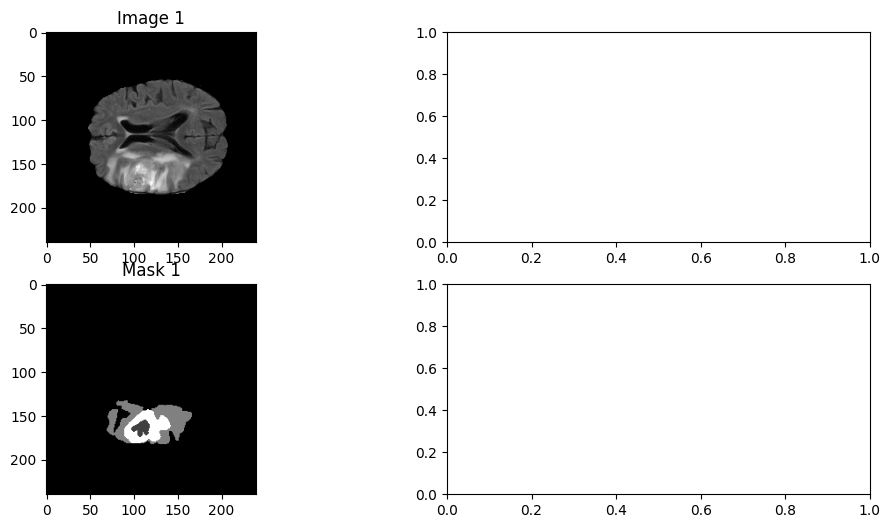

In [5]:
import matplotlib.pyplot as plt

# Load a batch from the training set
train_generator = load_data_in_batches(train_patients, batch_size)

# Get one batch of images and masks
images, masks = next(train_generator)

# Visualize some of the images and masks
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i in range(1):
    axes[0, i].imshow(images[i, :, :, images.shape[3]//2, 0], cmap='gray')
    axes[0, i].set_title(f"Image {i+1}")
    axes[1, i].imshow(masks[i, :, :, masks.shape[3]//2], cmap='gray')
    axes[1, i].set_title(f"Mask {i+1}")
plt.show()


In [6]:
# Define U-Net model architecture
def unet_model(input_shape=(240, 240, 155, 3)):
    inputs = layers.Input(shape=input_shape)
    
    # Encoder
    c1 = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    
    c2 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)
    
    # Decoder
    u1 = layers.UpSampling3D((2, 2, 2))(p2)
    c3 = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(u1)
    
    u2 = layers.UpSampling3D((2, 2, 2))(c3)
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(u2)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Instantiate model
model = unet_model()

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


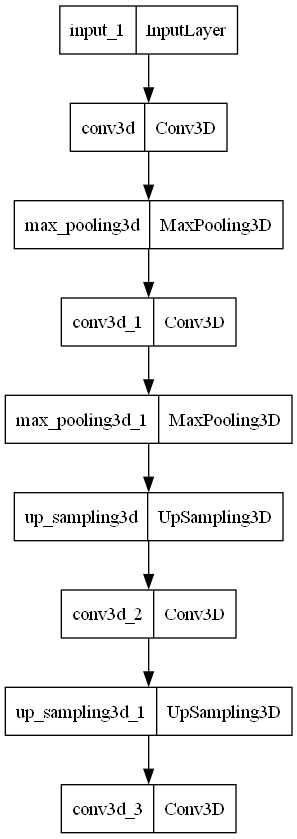

In [8]:

from tensorflow.keras.utils import plot_model
plot_model(model)

In [9]:
# Custom metric function for precision, recall, and f1-score
def calculate_metrics(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = (y_pred.flatten() > 0.5).astype(np.uint8)

    acc = accuracy_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)

    return acc, precision, recall, f1


In [10]:
epochs = 10
steps_per_epoch = len(train_patients) // batch_size
validation_steps = len(val_patients) // batch_size

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    train_loss = 0
    val_loss = 0

    for step in range(steps_per_epoch):
        images, masks = next(train_generator)
        batch_loss = model.train_on_batch(images, masks)

        # Track metrics for every batch
        print(f"Epoch: {epoch+1}, Batch: {step+1}/{steps_per_epoch}, Loss: {batch_loss[0]}, Accuracy: {batch_loss[1]}")
        
        train_loss += batch_loss[0]

    # Validation at the end of each epoch
    val_images, val_masks = next(val_generator)
    val_loss, val_acc = model.evaluate(val_images, val_masks)
    
    # Metrics calculation
    acc, precision, recall, f1 = calculate_metrics(val_masks, model.predict(val_images))
    print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')


Epoch 1/10


ValueError: in user code:

    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\binwa\anaconda3\envs\mlenv\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((1, 240, 240, 152, 1) vs (1, 240, 240, 155, 1)).


In [11]:
# Save the model
model.save('unet_model.h5')
print("Model saved.")

# Load the model
loaded_model = models.load_model('unet_model.h5')
print("Model loaded.")


Model saved.
Model loaded.


In [ ]:
# Validate the loaded model
val_images, val_masks = next(val_generator)
predictions = loaded_model.predict(val_images)

# Plot the prediction vs ground truth for a few samples
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for i in range(1):
    # Ground truth mask
    axes[0, i].imshow(val_masks[i, :, :, val_masks.shape[3]//2], cmap='gray')
    axes[0, i].set_title(f"Ground Truth {i+1}")
    
    # Predicted mask
    axes[1, i].imshow(predictions[i, :, :, predictions.shape[3]//2], cmap='gray')
    axes[1, i].set_title(f"Predicted Mask {i+1}")
    
plt.tight_layout()
plt.show()

# Print final metrics for the validation data
acc, precision, recall, f1 = calculate_metrics(val_masks, predictions)
print(f'Final Metrics -> Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1-score: {f1}')


In [ ]:
# Load the trained model
model.load_state_dict(torch.load('tumor_segmentation_model.pth'))
model.eval()

# Validation
val_generator = load_data_in_batches(val_patients, batch_size)

# Iterate through the validation set and visualize results
for batch_idx, (images, masks) in enumerate(val_generator):
    images, masks = convert_to_tensor((images, masks), device)
    
    # Forward pass (no gradient calculation for validation)
    with torch.no_grad():
        outputs = model(images)
    
    pred_masks = outputs.detach().cpu().numpy().round()
    true_masks = masks.cpu().numpy()
    
    # Calculate metrics
    val_acc = accuracy_score(true_masks.flatten(), pred_masks.flatten())
    val_prec = precision_score(true_masks.flatten(), pred_masks.flatten(), zero_division=0)
    val_recall = recall_score(true_masks.flatten(), pred_masks.flatten(), zero_division=0)
    val_f1 = f1_score(true_masks.flatten(), pred_masks.flatten(), zero_division=0)

    # Print metrics for each batch
    print(f"Validation Batch [{batch_idx+1}], "
          f"Acc: {val_acc:.4f}, Prec: {val_prec:.4f}, "
          f"Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
    
    # Visualize ground truth vs prediction for the current batch
    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    
    # Original Image
    axes[0, 0].imshow(images.cpu().numpy()[0, 0, :, :, images.shape[3]//2], cmap='gray')
    axes[0, 0].set_title("Original Image")

    # Ground Truth Mask
    axes[0, 1].imshow(true_masks[0, :, :, true_masks.shape[3]//2], cmap='gray')
    axes[0, 1].set_title("Ground Truth Mask")

    # Predicted Mask
    axes[1, 1].imshow(pred_masks[0, :, :, pred_masks.shape[3]//2], cmap='gray')
    axes[1, 1].set_title("Predicted Mask")
    
    plt.show()

    if batch_idx == 0:  # Stop after visualizing the first batch
        break
